# Poisson HMM Example Notebook

Based on https://github.com/lindermanlab/ssm-jax/blob/main/notebooks/poisson-hmm-example.ipynb


In [2]:
try:
    import ssm_jax
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/ssm-jax.git
    import ssm_jax

#### Imports and Plotting Functions 

In [3]:
import warnings
from functools import partial

import jax.numpy as jnp
import jax.random as jr
from jax import vmap
from jax import jit

import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

from scipy.optimize import linear_sum_assignment

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from ssm_jax.hmm.models import PoissonHMM

In [4]:
def compute_state_overlap(z1, z2, K1=None, K2=None):
    assert z1.dtype == jnp.int32 and z2.dtype == jnp.int32
    assert z1.shape == z2.shape
    assert z1.min() >= 0 and z2.min() >= 0

    K1 = z1.max() + 1 if K1 is None else K1
    K2 = z2.max() + 1 if K2 is None else K2

    overlap = jnp.zeros((K1, K2))
    for k1 in range(K1):
        for k2 in range(K2):
            overlap.at[k1, k2].set(jnp.sum((z1 == k1) & (z2 == k2)))
    return overlap


def find_permutation(z1, z2, K1=None, K2=None):
    overlap = compute_state_overlap(z1, z2, K1=K1, K2=K2)
    K1, K2 = overlap.shape

    tmp, perm = linear_sum_assignment(-overlap)
    # assert jnp.all(tmp == np.arange(K1)), "All indices should have been matched!"

    # Pad permutation if K1 < K2
    if K1 < K2:
        unused = jnp.array(list(set(jnp.arange(K2)) - set(perm)))
        perm = jnp.concatenate((perm, unused))

    return perm

In [5]:
def gradient_cmap(colors, nsteps=256, bounds=None):
    """Return a colormap that interpolates between a set of colors.
    Ported from HIPS-LIB plotting functions [https://github.com/HIPS/hips-lib]
    Reference:
    https://github.com/lindermanlab/ssm/blob/646e1889ec9a7efb37d4153f7034c258745c83a5/ssm/plots.py#L20
    """
    ncolors = len(colors)
    # assert colors.shape[1] == 3
    if bounds is None:
        bounds = jnp.linspace(0, 1, ncolors)

    reds = []
    greens = []
    blues = []
    alphas = []
    for b, c in zip(bounds, colors):
        reds.append((b, c[0], c[0]))
        greens.append((b, c[1], c[1]))
        blues.append((b, c[2], c[2]))
        alphas.append((b, c[3], c[3]) if len(c) == 4 else (b, 1.0, 1.0))

    cdict = {"red": tuple(reds), "green": tuple(greens), "blue": tuple(blues), "alpha": tuple(alphas)}

    cmap = LinearSegmentedColormap("grad_colormap", cdict, nsteps)
    return cmap

In [6]:
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue", "red", "amber", "faded green", "dusty purple", "orange"]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


def plot_transition_matrix(transition_matrix):
    plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
    plt.xlabel("next state")
    plt.ylabel("current state")
    plt.colorbar()
    plt.show()


def compare_transition_matrix(true_matrix, test_matrix):
    fig, axs = plt.subplots(1, 2)
    out = axs[0].imshow(true_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[1].imshow(test_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[0].set_title("True Transition Matrix")
    axs[1].set_title("Test Transition Matrix")
    cax = fig.add_axes(
        [
            axs[1].get_position().x1 + 0.07,
            axs[1].get_position().y0,
            0.02,
            axs[1].get_position().y1 - axs[1].get_position().y0,
        ]
    )
    plt.colorbar(out, cax=cax)
    plt.show()


def plot_hmm_data(obs, states):
    lim = 1.01 * abs(obs).max()
    time_bins, obs_dim = obs.shape
    plt.figure(figsize=(8, 3))
    plt.imshow(
        states[None, :],
        aspect="auto",
        cmap=cmap,
        vmin=0,
        vmax=len(colors) - 1,
        extent=(0, time_bins, -lim, (obs_dim) * lim),
    )

    for d in range(obs_dim):
        plt.plot(obs[:, d] + lim * d, "-k")

    plt.xlim(0, time_bins)
    plt.xlabel("time")
    plt.yticks(lim * jnp.arange(obs_dim), ["$x_{}$".format(d + 1) for d in range(obs_dim)])

    plt.title("Simulated data from an HMM")

    plt.tight_layout()


def plot_posterior_states(Ez, states, perm):
    plt.figure(figsize=(20, 2))
    plt.imshow(Ez.T[perm], aspect="auto", interpolation="none", cmap="Greys")
    plt.plot(states, label="True State")
    plt.plot(Ez.T[perm].argmax(axis=0), "--", label="Predicted State")
    plt.xlabel("time")
    plt.ylabel("latent state")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title("Predicted vs. Ground Truth Latent State")
    plt.show()

# 2. Poisson HMM

### As before, let's create a true model

In [7]:
num_states = 5
num_neurons = 10
hmm = PoissonHMM(num_states, num_neurons)

true_params, param_props = hmm.random_initialization(jr.PRNGKey(0))
true_params["initial"]["probs"] = jnp.ones((num_states,)) / (num_states * 1.0)
true_params["transitions"]["transition_matrix"] = 0.90 * jnp.eye(num_states) + 0.10 * jnp.ones((num_states, num_states)) / num_states

means_prior = tfd.Gamma(3.0, 1.0)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    true_params["emissions"]["rates"] = means_prior.sample(seed=jr.PRNGKey(0), sample_shape=(num_states, num_neurons))


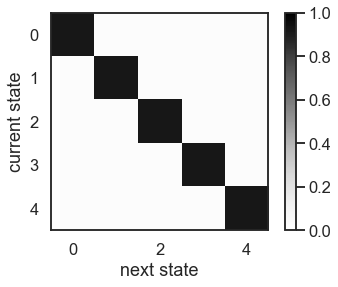

In [8]:
plot_transition_matrix(true_params["transitions"]["transition_matrix"])

### Acessing model parameters
The HMM was initialized with a transition matrix, but what about the emission rates? Unless they are explicitly given to the constructor, they are initialized randomly using the specified seed.  We can access them via model properties.

In [9]:
print("Emission probabilities (num states x num emission_dims (aka channels)):")
print(true_params["emissions"]["rates"])

Emission probabilities (num states x num emission_dims (aka channels)):
[[2.3273106  4.7042933  4.7147727  3.6188836  1.8785722  2.9218767
  3.2418182  1.0737236  0.9520292  3.681632  ]
 [3.373829   4.506029   1.0604832  1.7568105  4.019825   2.425489
  4.0328975  4.3800173  2.8734431  1.8425262 ]
 [1.9034142  1.7478418  1.6828955  2.7750566  2.4077315  0.31438544
  4.410909   3.0964594  1.5256848  2.0441117 ]
 [3.3966694  3.3942928  6.420209   1.9779935  1.7987707  1.5110977
  1.0246713  6.001985   3.000935   4.5368776 ]
 [1.1979313  1.7388443  3.918428   1.9244614  3.131378   7.542577
  1.809742   3.6445246  2.389298   2.2099392 ]]


### From the true model, we can sample synthetic data

In [10]:
rng = jr.PRNGKey(0)
num_timesteps = 2000

# There's an annoying warning/bug when sampling from Poisson TFP distributions
# currently. We can suppress the warning here for convenience
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", "Explicitly requested dtype")
    states, emissions = hmm.sample(true_params, rng, num_timesteps)

### Let's view the synthetic data

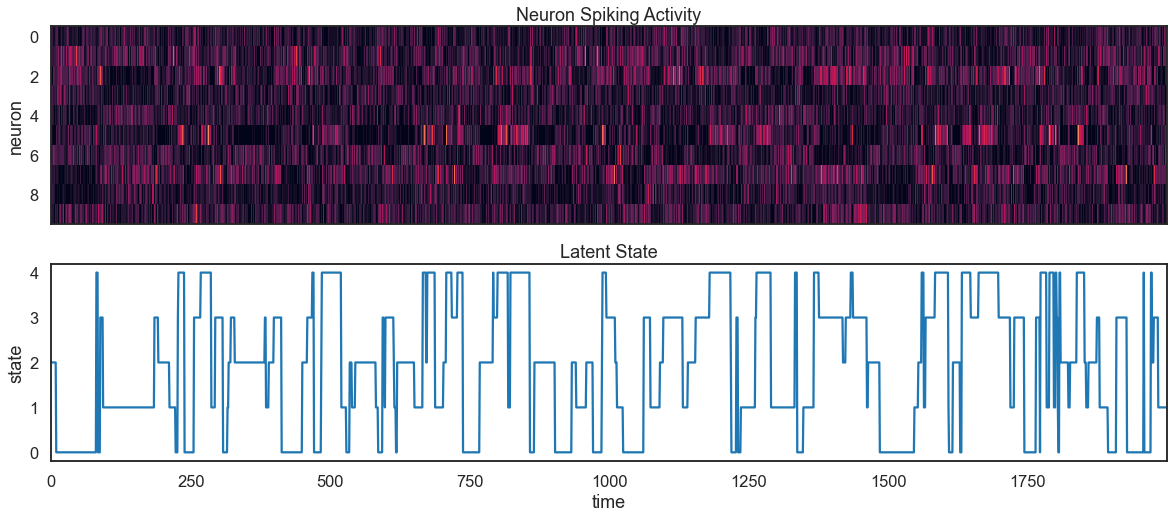

In [11]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
axs[0].imshow(emissions.T, aspect="auto", interpolation="none")
axs[0].set_ylabel("neuron")
axs[0].set_title("Neuron Spiking Activity")
axs[1].plot(states)
axs[1].set_title("Latent State")
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")
plt.show()

## Fit HMM using exact EM update

In [12]:
test_params, param_props = hmm.random_initialization(jr.PRNGKey(1234))
test_hmm, lps = hmm.fit_em(test_params, param_props, emissions[None, ...])

100%|██████████| 50/50 [00:00<00:00, 53.34it/s]


Text(0, 0.5, 'log likelihood')

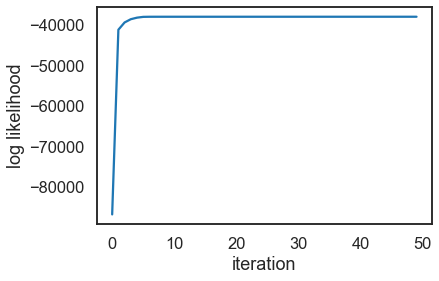

In [13]:
# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")

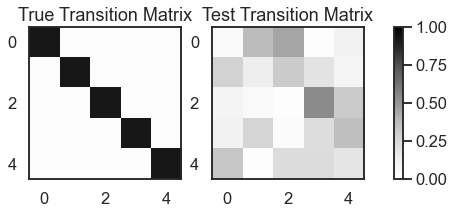

In [14]:
# Compare the transition matrices
compare_transition_matrix(true_params["transitions"]["transition_matrix"], 
                          test_params["transitions"]["transition_matrix"])

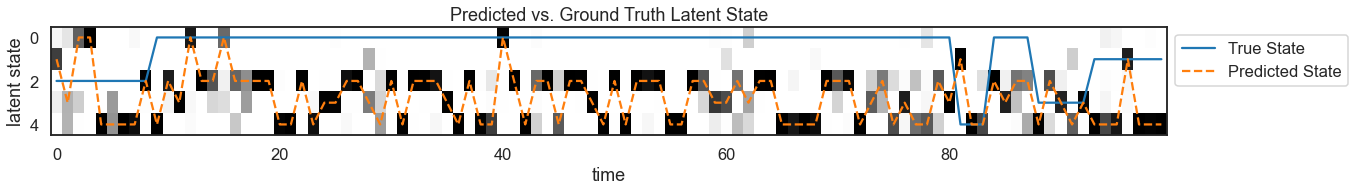

In [15]:
# Posterior distribution
posterior = hmm.smoother(test_params, emissions)
Ez = posterior.smoothed_probs
perm = find_permutation(states, jnp.argmax(Ez, axis=-1))
plot_posterior_states(Ez[:100], states[:100], perm)

## Fit Poisson HMM over multiple trials

In [16]:
key = jr.PRNGKey(0)
num_trials = 5
num_timesteps = 500

# once again, we suppress the warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", "Explicitly requested dtype")
    all_states, all_emissions = vmap(partial(hmm.sample, true_params, num_timesteps=num_timesteps))(
        jr.split(key, num_trials))

In [17]:
# Now we have a batch dimension of size `num_trials`
print(all_states.shape)
print(all_emissions.shape)

(5, 500)
(5, 500, 10)


In [18]:
test_params, param_props = hmm.random_initialization(jr.PRNGKey(2))
test_params, lps = hmm.fit_em(test_params, param_props, all_emissions, num_iters=100)

100%|██████████| 100/100 [00:01<00:00, 96.12it/s]


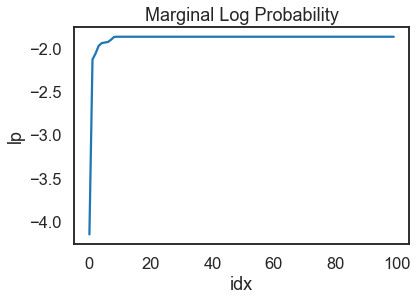

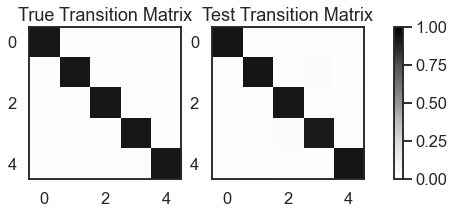

In [19]:
# plot marginal log probabilities
plt.title("Marginal Log Probability")
plt.ylabel("lp")
plt.xlabel("idx")
plt.plot(jnp.array(lps) / all_emissions.size)

compare_transition_matrix(true_params["transitions"]["transition_matrix"], 
                          test_params["transitions"]["transition_matrix"])

===== Trial: 0 =====


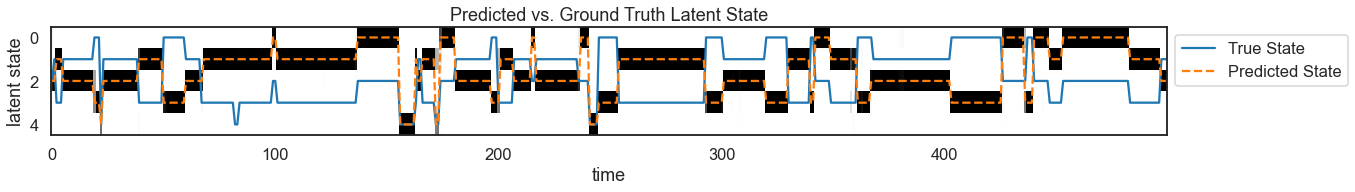

===== Trial: 1 =====


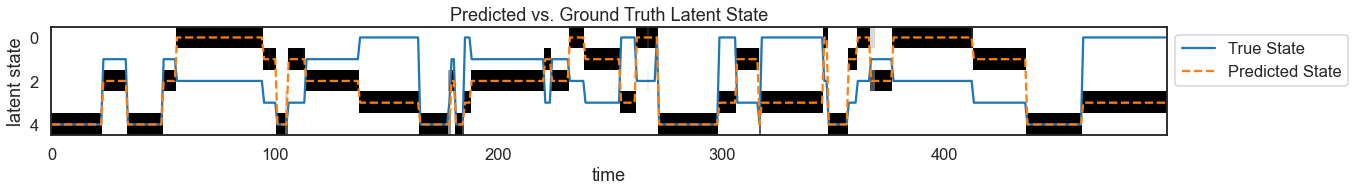

===== Trial: 2 =====


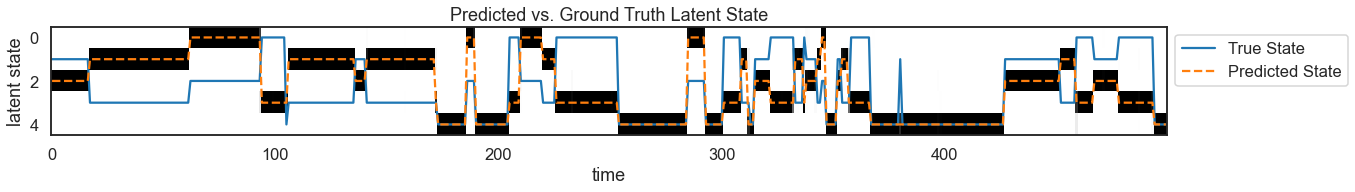

In [20]:
for trial_idx in range(3):
    print("=" * 5, f"Trial: {trial_idx}", "=" * 5)
    posterior = hmm.smoother(test_params, all_emissions[trial_idx])
    Ez = posterior.smoothed_probs
    states = all_states[trial_idx]
    perm = find_permutation(states, jnp.argmax(Ez, axis=-1))
    plot_posterior_states(Ez, states, perm)